# Flipkart Reviews
# Sentiment Analysis Using Python

### About Flipkart dataset:

- Flipkart is primarily known as an online marketplace where customers can browse, select, and purchase a diverse array of products.
- Flipkart Private Limited is an Indian e-commerce company.
- The company initially focused on online book sales before expanding into other product categories such as consumer electronics, fashion, home essentials, groceries, and lifestyle products.
- As of March 2017, Flipkart held a 39.5% market share in the Indian e-commerce industry.


## About the data variables:

- Contains 2 variables: Review variable and its corresponding Rating variable which given by the users on Flipkart.
Review is string; Rating is number which scales by 1 to 5

- Goal:
To predict whether the review given is positive or negative



# Importing Libraries and Datasets

In [10]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import re
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from plotnine.themes.theme_classic import theme_classic
from plotnine import ggplot, aes, geom_bar, labs, theme
from xgboost import XGBClassifier

In [11]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
path = "flipkart_data.csv"

In [14]:
flipkart = pd.read_csv(path)
flipkart.head()

,review,rating
0,It was nice produt. I like it's design a lot. ...,5
1,awesome sound....very pretty to see this nd th...,5
2,awesome sound quality. pros 7-8 hrs of battery...,4
3,I think it is such a good product not only as ...,5
4,awesome bass sound quality very good bettary l...,5


In [15]:
flipkart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9976 entries, 0 to 9975
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  9976 non-null   object
 1   rating  9976 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 156.0+ KB


## Check duplicate and remove it

In [16]:
flipkart.head()
flipkart.tail()

,review,rating
9971,GoodREAD MORE,5
9972,Everything is amazimg but the built is very li...,5
9973,GoodREAD MORE,5
9974,Best headphone i have ever used....READ MORE,5
9975,NiceREAD MORE,5


In [17]:
print("Original DataFrame shape:", flipkart.shape)

# Create a new DataFrame without duplicates
flipkart2 = flipkart.drop_duplicates()
print("New DataFrame shape:", flipkart2.shape)

Original DataFrame shape: (9976, 2)
New DataFrame shape: (7868, 2)


## Splitting data into 5, 4, 3 as postive reviews and 2, 1 as negative reviews


In [18]:
# Rating label

flipkart2 = flipkart2.reset_index(drop=True)

pos_neg1 = []
for i in range(len(flipkart2['rating'])):
    if flipkart2['rating'][i] >= 3:
        pos_neg1.append(1)
    else:
        pos_neg1.append(0)
flipkart2['label'] = pos_neg1  # Assign to flipkart2, not flipkart
ratings = flipkart2["label"].value_counts()
numbers = ratings.index
quantity = ratings.values

In [19]:
flipkart2["label"].value_counts()

1    6957
0     911
Name: label, dtype: int64

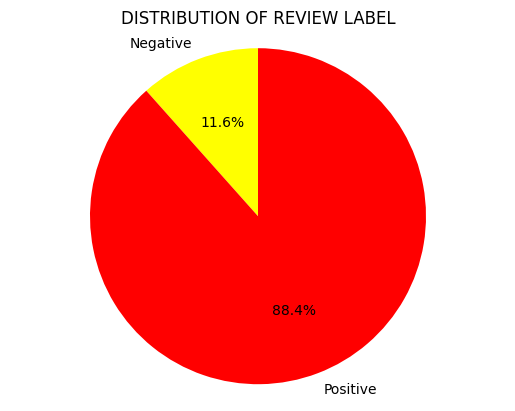

In [20]:
# Pie chart presents negative and positive reviews

labels1 = ['Negative', 'Positive']
sizes1 = [911, 6957]

plt.pie(sizes1, labels = labels1, autopct = '%1.1f%%', startangle = 90, colors=["yellow", "red"])

plt.title('DISTRIBUTION OF REVIEW LABEL')

plt.axis('equal')
plt.show()

# After dropping duplicate values, the dataset becomes imbalanced.

## Clean the text stopword and punctuation

In [21]:
# Customize stopword as per data

stop_words = stopwords.words('english')
new_stopwords = ["would","shall","could","might","battery","headphone",
                 "product","bluetooth","bass","headphones", "read"]
stop_words.extend(new_stopwords)
stop_words.remove("not")
stop_words = set(stop_words)
print(stop_words)

{'doesn', 'here', 'do', 'such', 'haven', 'needn', 'between', 'no', 'them', 'wasn', 'through', "didn't", "she's", 'headphones', 'a', "mightn't", 'where', 'into', 'was', 't', 'how', 'all', 'bass', 'while', "you've", 'will', 'have', 'about', 'should', 'both', 'below', 'and', "you'll", "aren't", 'll', 'hers', 'these', 'it', 'does', 'me', 'your', 'theirs', 've', 'shan', 'm', 'mustn', 'doing', 'if', 'has', 'again', 'd', 'we', 'yours', "shouldn't", 'they', 'would', 'few', "should've", 'headphone', 'hadn', 'in', 'my', 'be', 'our', 'some', 'his', "won't", 'under', 'than', 'at', 'isn', 'ma', "don't", 'own', 'its', "wasn't", 'ain', 'did', 'before', "isn't", 'whom', "you're", 'itself', 'having', 'couldn', 'against', 'hasn', 'might', 'there', 'battery', 'herself', 'same', 'off', "that'll", 'themselves', 'who', 'too', 'is', 'after', 'him', 'more', 'mightn', 'y', 'further', 'shall', 'for', 'each', 'once', 'down', 'during', 'been', 'from', 'of', 'bluetooth', 'aren', 'most', 'she', 'what', "weren't", '

In [22]:
'''-----------------------------Data Cleaning and Preprocessing Pipeline----------------------------------'''

# Removing special character

def remove_special_character(content):
    return re.sub('\W+',' ', content )

# Removing URL's

def remove_url(content):
    return re.sub(r'http\S+', '', content)

#Removing the stopwords from text
def remove_stopwords(content):
    clean_data = []
    for i in content.split():
        if i.strip().lower() not in stop_words and i.strip().lower().isalpha():
            clean_data.append(i.strip().lower())
    return " ".join(clean_data)

# Expansion of english contractions
def contraction_expansion(content):
    content = re.sub(r"won\'t", "would not", content)
    content = re.sub(r"can\'t", "can not", content)
    content = re.sub(r"don\'t", "do not", content)
    content = re.sub(r"shouldn\'t", "should not", content)
    content = re.sub(r"needn\'t", "need not", content)
    content = re.sub(r"hasn\'t", "has not", content)
    content = re.sub(r"haven\'t", "have not", content)
    content = re.sub(r"weren\'t", "were not", content)
    content = re.sub(r"mightn\'t", "might not", content)
    content = re.sub(r"didn\'t", "did not", content)
    content = re.sub(r"n\'t", " not", content)
    content = re.sub(r"productread", "product read", content)
    return content

#Data preprocessing
def data_cleaning(content):
    content = contraction_expansion(content)
    content = remove_special_character(content)
    content = remove_url(content)
    content = remove_stopwords(content)
    return content

In [23]:
# Data cleaning

flipkart2['reviews_clean']= flipkart2['review'].apply(data_cleaning)
flipkart2.head(5)

,review,rating,label,reviews_clean
0,It was nice produt. I like it's design a lot. ...,5,1,nice produt like design lot easy carry looked ...
1,awesome sound....very pretty to see this nd th...,5,1,awesome sound pretty see nd sound quality good...
2,awesome sound quality. pros 7-8 hrs of battery...,4,1,awesome sound quality pros hrs life including ...
3,I think it is such a good product not only as ...,5,1,think good not per quality also design quite g...
4,awesome bass sound quality very good bettary l...,5,1,awesome sound quality good bettary long life p...


## Wordcloud Visulaiztion

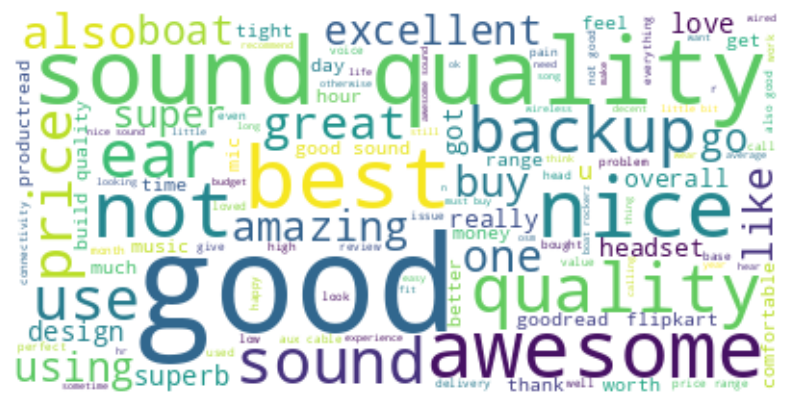

In [24]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

# Viusualize positive reviews

plt.figure(figsize=(10, 5))

text1 = flipkart2[flipkart2.label==1].review.tolist()

# Join the list and lowercase all the words
text1 = ' '.join(text1).lower()

# Create the wordcloud object
wordcloud = WordCloud(stopwords = stop_words,
                      background_color = 'white',
                      collocations = True).generate(text1)

plt.imshow(wordcloud, interpolation = 'bilInear')
plt.axis('off')
plt.show()

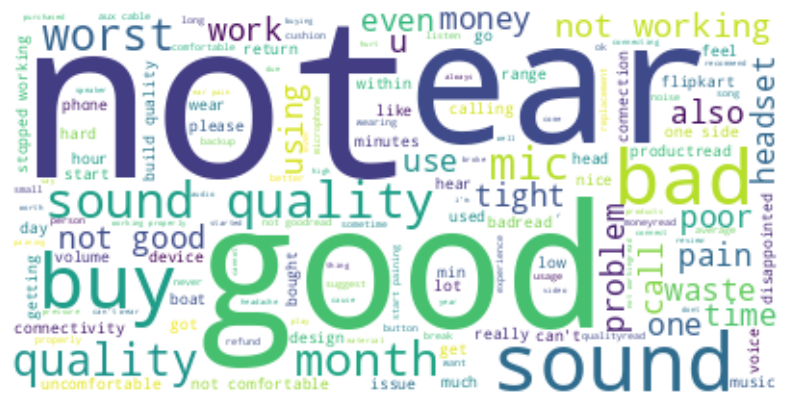

In [25]:
# Viusualize negative reviews

plt.figure(figsize=(10, 5))

text0 = flipkart2[flipkart2.label==0].review.tolist()
text0 = ' '.join(text0).lower()

wordcloud = WordCloud(stopwords = stop_words,
                      background_color='white',
                      collocations=True).generate(text0)

plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

In [26]:
# 10 common words with label "1" (Positive reviews)

from collections import Counter

label_1_df = flipkart2[flipkart2['label'] == 1]

text_for_label_1 = ' '.join(label_1_df['reviews_clean'])
words = text_for_label_1.split()
word_counts = Counter(words)
most_common_words = word_counts.most_common(10)
print("Most common words in 'Text' with Label=1:")
for word, count in most_common_words:
    print(f"{word}: {count}")

Most common words in 'Text' with Label=1:
good: 3967
sound: 2487
quality: 2309
not: 1810
nice: 1152
best: 1080
awesome: 992
price: 843
also: 636
backup: 569


In [27]:
# 10 common words with label "1" (Negative reviews)

label_0_df = flipkart2[flipkart2['label'] == 0]
text_for_label_0 = ' '.join(label_0_df['reviews_clean'])
words = text_for_label_0.split()
word_counts = Counter(words)
most_common_words = word_counts.most_common(10)

print("Most common words in 'Text' with Label=0:")
for word, count in most_common_words:
    print(f"{word}: {count}")

Most common words in 'Text' with Label=0:
not: 681
good: 213
sound: 206
quality: 200
buy: 130
working: 125
bad: 122
ears: 102
worst: 81
mic: 78


In [28]:
#  Convert Text to Vector-(TF-IDF)

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import issparse

cv = TfidfVectorizer(max_features = 2500)
X1 = cv.fit_transform(flipkart2['reviews_clean'] ).toarray()

if issparse(X1):
    if not X.nnz:
        print("The TF-IDF matrix is entirely composed of zeros.")
    else:
        print("The TF-IDF matrix is sparse but contains non-zero elements.")
else:
    print("The TF-IDF matrix is not sparse.")

The TF-IDF matrix is not sparse.


In [29]:
X1.shape

(7868, 2500)

In [30]:
X1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Applying Machine Learning Models

In [31]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import numpy as np
import pandas as pd
from scipy.stats import randint

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import make_scorer, classification_report, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [32]:
# Train & Test Split

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, flipkart2['label'],
													test_size = 0.2,
													stratify= flipkart2['label'],
                          random_state = 42)

In [33]:
def compute_accuracy_AUC(Model, y_test, y_hat, pred_prob):
    if len(pred_prob.shape) == 1:
        fpr, tpr, thresholds = roc_curve(y_test, pred_prob)
    else:
        fpr, tpr, thresholds = roc_curve(y_test, pred_prob[:, 1])

    AUC = auc(fpr, tpr)
    print(f'{Model} model has AUC {AUC}')
    return AUC

** Logistic Regression Model

In [34]:
# Logistic Regression Model

# Fit the model

lr_model = LogisticRegression(random_state = 0)
lr_model = lr_model.fit(X_train1, y_train1)

# Predict the sentiment on the test data

y_pred1 = lr_model.predict(X_test1)

# Calculate and print the accuracy of the model

accuracy = accuracy_score(y_test1, y_pred1)
print(f"Accuracy of the Logistic Regression model: {accuracy:.2f}")

# Compute the probabilities

y_prob = lr_model.predict_proba(X_test1)[:, 1]

# Compute AUC

model_AUC_lg = roc_auc_score(y_test1, y_prob)
print(f"AUC of the Logistic Regression model: {model_AUC_lg:.2f}")

# Compute F1 score for Logistic Regression model

f1_lr = f1_score(y_test1, y_pred1)

print(f"F1 Score of the Logistic Regression model: {f1_lr:.2f}")

Accuracy of the Logistic Regression model: 0.92
AUC of the Logistic Regression model: 0.94
F1 Score of the Logistic Regression model: 0.96


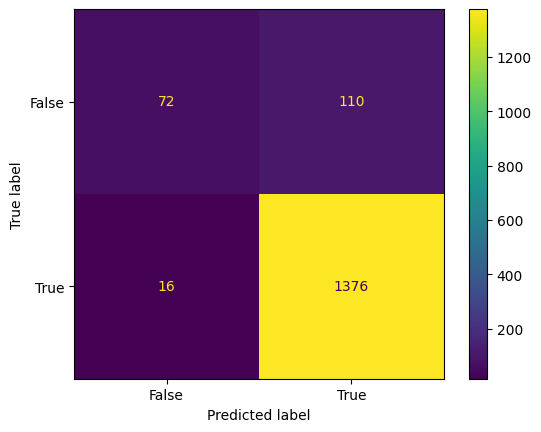

In [35]:
# Create a Confusion Matrix

from sklearn import metrics

cm = confusion_matrix(y_test1,y_pred1)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,
											display_labels = [False, True])

cm_display.plot()
plt.show()

** Random Forest Classifier Model

In [57]:
# Random Forest Classifier Model

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

ratio = flipkart2['label'].value_counts()[1]/ flipkart2['label'].value_counts()[0]

# Class_weight (new code)
cl_weight = {0: 1, 1: ratio}

rf_model = RandomForestClassifier(class_weight=cl_weight, random_state=0)
rf_model.fit(X_train1, y_train1)

y_pred_rf = rf_model.predict(X_test1)

y_prob_rf = rf_model.predict_proba(X_test1)[:, 1]

rf_accuracy = accuracy_score(y_test1, y_pred_rf)
print(f"The accuracy of the Random Forest model: {rf_accuracy:.2f}")

f1_rf = f1_score(y_test1, y_pred_rf)
print(f"F1 score of the Random Forest model: {f1_rf:.2f}")

The accuracy of the Random Forest model: 0.92
F1 score of the Random Forest model: 0.95


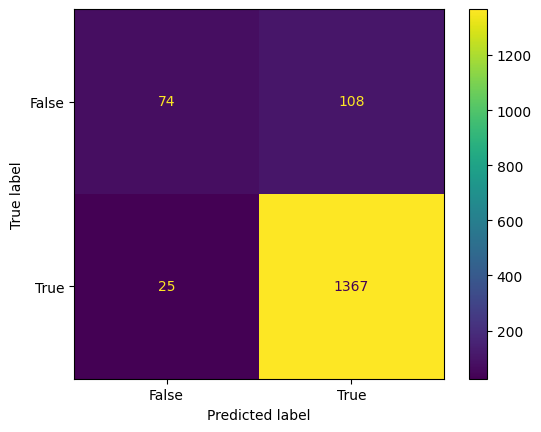

In [37]:
# Confusion Matrix
cm = confusion_matrix(y_test1,y_pred_rf)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,
											display_labels = [False, True])

cm_display.plot()
plt.show()

** XGBoost Model

In [38]:
# XGBoost has a parameter scale_pos_weight that helps in handling imbalanced datasets.

y = flipkart2['label']
ratio = float(np.sum(y == 0)) / np.sum(y == 1)

xgb = XGBClassifier(scale_pos_weight = ratio)

xgb.fit(X_train1, y_train1)

y_pred_xgb = xgb.predict(X_test1)

y_prob_xgb = xgb.predict_proba(X_test1)[:, 1]

rgb_accuracy = accuracy_score(y_test1, y_pred_rf)
print(f"The accuracy of the XGBoost model: {rf_accuracy:.2f}")

auc_xgb = roc_auc_score(y_test1, y_prob_xgb)
print(f"AUC of the XGBoost model: {auc_xgb:.2f}")

f1_xgb = f1_score(y_test1, y_pred_xgb)

print(f"F1 score of the XGBoost model: {f1_xgb:.2f}")

The accuracy of the XGBoost model: 0.92
AUC of the XGBoost model: 0.92
F1 score of the XGBoost model: 0.91


** Support Vector Machines(SVM)

In [39]:
svm_model = SVC(class_weight = cl_weight,probability = True)
svm_model.fit(X_train1, y_train1)

y_pred_svc = svm_model.predict(X_test1)

accuracy_svc = accuracy_score(y_test1, y_pred_svc)
print(f"Accuracy of the SVM model: {accuracy_svc:.2f}")

y_pred= svm_model.predict(X_test1)
y_prob= svm_model.predict_proba(X_test1)[:, 1]

model_AUC_svm = compute_accuracy_AUC('Support Vector Machines', y_test1, y_pred,  y_prob)

f1_svc = f1_score(y_test1, y_pred_svc)
print(f"F1 score of the SVM model: {f1_svc:.2f}")

Accuracy of the SVM model: 0.92
Support Vector Machines model has AUC 0.9252478842996084
F1 score of the SVM model: 0.96


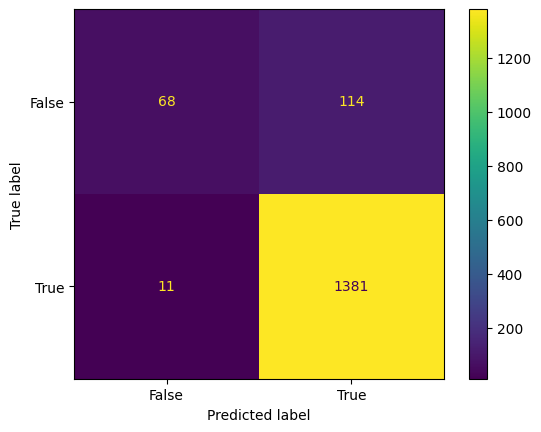

In [40]:
# Confusion Matrix

cm = confusion_matrix(y_test1,y_pred_svc)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,
											display_labels = [False, True])

cm_display.plot()
plt.show()

** Cross Validation Model

In [61]:
# Hyper parameter tuning.

from sklearn.metrics import auc

par_grid = dict(max_depth = randint(low = 2, high = 6), n_estimators=randint(low = 50, high = 150), \
    min_samples_split = randint(low = 2, high = 6), max_samples = [0.3, 0.5, 0.7, 0.9] )

cv_model = random_search.fit(X_train1, y_train1)

# Generate predictions and probabilities
y_pred_cv_rf = cv_model.predict(X_test1)
y_prob_cv_rf = cv_model.predict_proba(X_test1)[:, 1]

# Compute the AUC for the Cross Validation-RF model
auc_cv_rf = compute_accuracy_AUC('Cross Validation-RF', y_test1, y_pred_cv_rf, y_prob_cv_rf)

Cross Validation-RF model has AUC 0.90551582038651


In [65]:
# Instantiate the RandomizedSearchCV object with 'f1' scoring

random_search = RandomizedSearchCV(rf, par_grid, cv = 5, scoring = 'f1', n_jobs = -1,random_state=42)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X_train1, y_train1)

print(f"Best parameters: {random_search.best_params_}")
print(f"Best F1 score: {random_search.best_score_:.2f}")

Best parameters: {'max_depth': 4, 'max_samples': 0.9, 'min_samples_split': 2, 'n_estimators': 64}
Best F1 score: 0.94


## Comparision of F1 scores

In [66]:
print(f"F1 Score of the Logistic Regression model: {f1_lr:.2f}")
print(f"F1 Score of the Random Forest Classifier model: {f1_rf:.2f}")
print(f"F1 score of the XGBoost model: {f1_xgb:.2f}")
print(f"F1 score of the Support Vector Machine model: {f1_svc:.2f}")
print(f"F1 Score of the Cross Validation model: {random_search.best_score_:.2f}")

F1 Score of the Logistic Regression model: 0.96
F1 Score of the Random Forest Classifier model: 0.95
F1 score of the XGBoost model: 0.91
F1 score of the Support Vector Machine model: 0.96
F1 Score of the Cross Validation model: 0.94


## Comparison of AUC Scores

In [67]:
print(f"AUC score of the Logistic Regression model: {model_AUC_lg:.2f}")
print(f"AUC score of the Random Forest model: {model_AUC_rf:.2f}")
print(f"AUC score of the XGBoost model: {auc_xgb:.2f}")
print(f"AUC score of the Support Vector Machine model: {model_AUC_svm:.2f}")
print(f"AUC score of the Cross Validation model: {auc_rcv:.2f}")

AUC score of the Logistic Regression model: 0.94
AUC score of the Random Forest model: 0.90
AUC score of the XGBoost model: 0.92
AUC score of the Support Vector Machine model: 0.93
AUC score of the Cross Validation model: 0.90


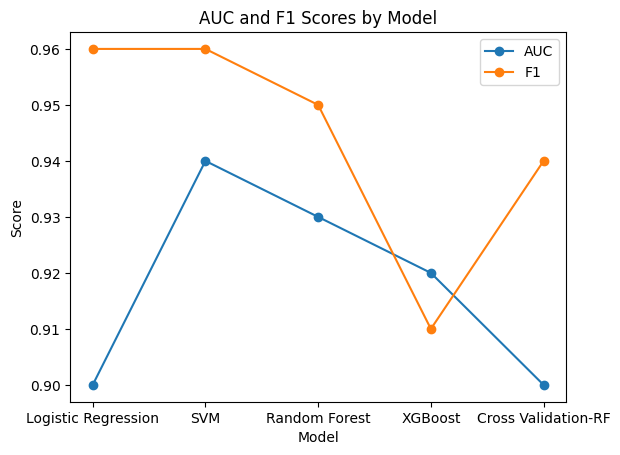

In [78]:
import matplotlib.pyplot as plt

# Visualizing AUC and F1 Scores

model = ['Logistic Regression', 'SVM', 'Random Forest', 'XGBoost', 'Cross Validation-RF']
ACU = [0.94, 0.93, 0.90, 0.92, 0.90]
F1 = [0.96, 0.96, 0.95, 0.91, 0.94]

# Plotting AUC scores
plt.plot(model, auc, marker='o', label='AUC')

# Plotting F1 scores
plt.plot(model, f1, marker='o', label='F1')

# Adding labels and title
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('AUC and F1 Scores by Model')
plt.legend()  # Show legend for clarity

# Display the plot
plt.show()

## Summary

In [81]:
# SUMMARY

from prettytable import PrettyTable

model = ['Random Forest', 'Logistic Regression', 'Support Vector Machine', 'XGBoost', 'RandomizedCV']
AUC = [0.94, 0.93, 0.90, 0.92, 0.90]
F1 = [0.96, 0.96, 0.95, 0.91, 0.94]

# Creating a PrettyTable
table = PrettyTable()
table.field_names = ["Model", "AUC", "F1"]

# Adding data to the table
for m, a, f in zip(model, AUC, F1):
    table.add_row([m, a, f])

print(table)


+------------------------+------+------+
|         Model          | AUC  |  F1  |
+------------------------+------+------+
|     Random Forest      | 0.94 | 0.96 |
|  Logistic Regression   | 0.93 | 0.96 |
| Support Vector Machine | 0.9  | 0.95 |
|        XGBoost         | 0.92 | 0.91 |
|      RandomizedCV      | 0.9  | 0.94 |
+------------------------+------+------+


# Conclusion:

Based on the provided information about the hyperparameter tuning and the evaluation metrics (AUC and F1 scores), here's a conclusion:

- The AUC (Area Under the Receiver Operating Characteristic curve) is a metric that measures the ability of a model to distinguish between positive and negative classes. Higher AUC values indicate better model performance. The AUC scores provided are relatively high, ranging from 0.90 to 0.94. This suggests that the model has a good ability to discriminate between positive and negative reviews.

- The F1 score is the harmonic mean of precision and recall and provides a balance between these two metrics. It is commonly used when there is an uneven class distribution. The F1 scores provided are also high, ranging from 0.91 to 0.96. This indicates that the model performs well in terms of both precision and recall.

- In conclusion, based on the AUC and F1 scores, the high scores suggest that the model has good discriminatory power and is well-balanced in terms of precision and recall, and the hyperparameter-tuned model appears to be effective in predicting whether a Flipkart review is positive or negative.